In [1]:
from fastcore.all import *
import numpy as np
import torch
import random
import time

In [8]:
from torch import nn, optim

In [11]:
import torch.nn.functional as F

In [13]:
import numpy as np
import random
class Game2048:
    def __init__(self):
        self.size = 4
        self.score = 0
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.add_new_tile()
        self.add_new_tile()
        self.nomove = False
    def add_new_tile(self):
        empty_tiles = list(zip(*np.where(self.board == 0)))
        if empty_tiles:
            x, y = random.choice(empty_tiles)
            self.board[x][y] = 2 if random.random() < 0.9 else 4
    def move(self, direction):
        self.nomove = False
        prev_board = self.board.copy()
        if direction == 'down':
            self.board = np.rot90(self.board, -1)
            self._move_left()
            self.board = np.rot90(self.board)
        elif direction == 'up':
            self.board = np.rot90(self.board, 1)
            self._move_left()
            self.board = np.rot90(self.board, -1)
        elif direction == 'left':
            self._move_left()
        elif direction == 'right':
            self.board = np.fliplr(self.board)
            self._move_left()
            self.board = np.fliplr(self.board)
        self.nomove = np.abs(self.board - prev_board).sum()==0
        if self.nomove: return
        self.add_new_tile()
    def _move_left(self):
        self.reward = 0
        new_board = np.zeros((self.size, self.size), dtype=int)
        for i in range(self.size):
            row = self.board[i][self.board[i] != 0]
            new_row = []
            skip = False
            for j in range(len(row)):
                if skip:
                    skip = False
                    continue
                if j + 1 < len(row) and row[j] == row[j + 1]:
                    new_row.append(row[j] * 2)
                    self.score += row[j]*2
                    self.reward += row[j]*2
                    skip = True
                else:
                    new_row.append(row[j])
            new_board[i, :len(new_row)] = new_row
        self.board[:] = new_board
    def is_game_over(self):
        if not np.any(self.board == 0):
            for i in range(self.size):
                for j in range(self.size - 1):
                    if self.board[i][j] == self.board[i][j + 1] or \
                        self.board[j][i] == self.board[j + 1][i]:
                        return False
            return True
        return False
game = Game2048()
print(game.board)

[[0 0 0 0]
 [2 0 0 0]
 [0 0 0 0]
 [0 0 0 2]]


In [5]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvBlock, self).__init__()
        d = output_dim // 4
        self.conv1 = nn.Conv2d(input_dim, d, 1, padding='same')
        self.conv2 = nn.Conv2d(input_dim, d, 2, padding='same')
        self.conv3 = nn.Conv2d(input_dim, d, 3, padding='same')
        self.conv4 = nn.Conv2d(input_dim, d, 4, padding='same')

    def forward(self, x):
        x = x.to(device)
        output1 = self.conv1(x)
        output2 = self.conv2(x)
        output3 = self.conv3(x)
        output4 = self.conv4(x)
        return torch.cat((output1, output2, output3, output4), dim=1)

class DQN(torch.nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = ConvBlock(16, 2048)
        self.conv2 = ConvBlock(2048, 2048)
        self.conv3 = ConvBlock(2048, 2048)
        self.dense1 = nn.Linear(2048 * 16, 1024)
        self.dense2 = nn.Linear(1024, 4)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = nn.Flatten()(x)
        x = F.dropout(self.dense1(x))
        return self.dense2(x)

In [73]:
def mse_loss(pred, goal):
    return torch.mean((pred-goal)**2)    

In [108]:
def flatten(lst):
    return torch.tensor(lst).view(1, 4, 4)
mapping = {2**i: i for i in range(1, 16)}
mapping[0] = 0
def get_state(game):
    states = []
    for move in ['down', 'left', 'up', 'right']:
        new_game = Game2048()
        new_game.board = game.board.copy()
        new_game.move(move)
        states.append(flatten([[mapping[int(item)] for item in row] for row in game.board])) 
    states.append(flatten([[mapping[int(item)] for item in row] for row in game.board]))
    data = torch.stack(states, dim=1)
    return F.one_hot(data, 16).view(1, 80, 4, 4).float()

In [109]:
device= 'mps'
d = DQN()
d.to(device)
data = get_state(Game2048())

In [110]:
game = Game2048()

In [114]:
%%timeit -n 100
d(data)

2.7 ms ± 758 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [113]:
d(data)

tensor([[-0.0463,  0.0449, -0.0162, -0.0287]], device='mps:0',
       grad_fn=<LinearBackward0>)

In [63]:
from IPython.display import *

In [67]:
import matplotlib.pyplot as plt

In [68]:
clear_output

<function IPython.core.display_functions.clear_output(wait=False)>

In [143]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvBlock, self).__init__()
        d = output_dim // 4
        self.conv1 = nn.Conv2d(input_dim, d, 1, padding='same')
        self.conv2 = nn.Conv2d(input_dim, d, 2, padding='same')
        self.conv3 = nn.Conv2d(input_dim, d, 3, padding='same')
        self.conv4 = nn.Conv2d(input_dim, d, 4, padding='same')

    def forward(self, x):
        x = x.to(device)
        output1 = self.conv1(x)
        output2 = self.conv2(x)
        output3 = self.conv3(x)
        output4 = self.conv4(x)
        return torch.cat((output1, output2, output3, output4), dim=1)

class DQN(torch.nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = ConvBlock(80, 256)
        self.conv2 = ConvBlock(256, 256)
        self.conv3 = ConvBlock(256, 512)
        self.dense1 = nn.Linear(512 * 16, 512)
        self.dense2 = nn.Linear(512, 4)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = nn.Flatten()(x)
        x = F.dropout(self.dense1(x))
        return self.dense2(x)

In [138]:
class FullyConnectedQNetwork(nn.Module):
    def __init__(self, nin=80, nout=4):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nin, 192),
            nn.ReLU(),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, nout)
        )
    def forward(self, x):
        return self.model(x)

### Must implement experience replay

In [141]:
replay_memory = []
max_length = 10000

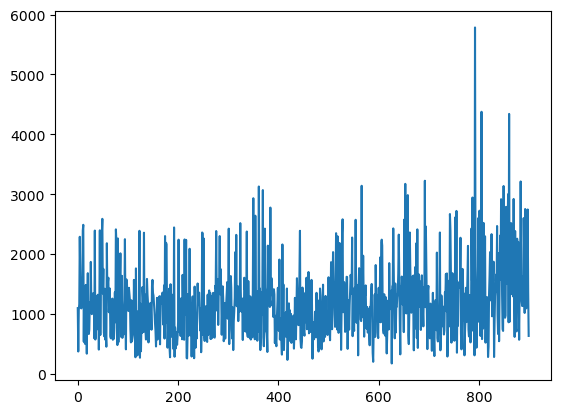

KeyboardInterrupt: 

In [145]:
device = 'mps'
episodes = 30
epsilons = np.geomspace(1, 0.01, episodes)
model = DQN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
gamma = 0.985
games_each_round = 50
avgs = []
stds = []
for epoch in range(episodes):
    experience_pool = []
    rewards = []
    if epoch % 5 == 0:
        experience_pool = experience_pool[5*batch_size:]
    t0 = time.time()
    for game_round in range(games_each_round):
        t1 = time.time()
        game = Game2048()
        while not game.is_game_over():
            state = get_state(game)
            if np.random.rand() > epsilons[epoch]:
                action = int(model(state).argmax())
            else:
                action = random.randint(0, 3)
            game.move(['down', 'left', 'up', 'right'][action])
            next_state = get_state(game)
            if game.nomove:
                reward = -20
            else:
                reward = game.reward
            if not game.is_game_over():
                replay_memory.append((state, action, reward, next_state))
            assert state.shape[1]==80
            """
            with torch.no_grad():
                target = reward + gamma*model(next_state).max()*(not game.is_game_over())
            
            experience_pool.append((state, action, target))
            """
        avgs.append(game.score)
        t2 = time.time()
    clear_output(wait=True)
    plt.plot(avgs)
    plt.show()
    batch_size = 8192
    if len(replay_memory) <= batch_size*3:
        continue
    """
    if len(replay_memory) > max_length:
        replay_memory.pop(0)
    """
    pool = random.sample(replay_memory, batch_size)
    states, actions, rewards, next_states = zip(*pool)
    
    X = torch.stack(states)
    X = X.squeeze(1)
    N = torch.stack(next_states).squeeze(1)
    y = torch.tensor(rewards, device=device) + gamma*model(N).max()
    q_values = model(X)
    try:
        chosen_q_values = q_values.gather(1, torch.tensor(actions).unsqueeze(1).to(device))
    except Exception:
        import pdb; pdb.set_trace()
    loss = mse_loss(chosen_q_values.squeeze(), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

In [129]:
random.sample?

Signature: random.sample(population, k, *, counts=None)
Docstring:
Chooses k unique random elements from a population sequence or set.

Returns a new list containing elements from the population while
leaving the original population unchanged.  The resulting list is
in selection order so that all sub-slices will also be valid random
samples.  This allows raffle winners (the sample) to be partitioned
into grand prize and second place winners (the subslices).

Members of the population need not be hashable or unique.  If the
population contains repeats, then each occurrence is a possible
selection in the sample.

Repeated elements can be specified one at a time or with the optional
counts parameter.  For example:

    sample(['red', 'blue'], counts=[4, 2], k=5)

is equivalent to:

    sample(['red', 'red', 'red', 'red', 'blue', 'blue'], k=5)

To choose a sample from a range of integers, use range() for the
population argument.  This is especially fast and space efficient
for sampling fro